<a href="https://colab.research.google.com/github/Nolanole/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_6_SOLUTION_EXAMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Make 2+ visualizations to explore relationships between features and target.
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

52.7%, which is the frequency of the majority class (`shot_made_flag == 0`).

This number is `1 - Field Goal Percentage` for this dataset.

In [3]:
df['shot_made_flag'].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df = df.set_index('game_date')
train = df[:'2018-09:30']
test = df['2018-10-01':]

In [5]:
test.index

Index(['2018-10-16', '2018-10-16', '2018-10-16', '2018-10-16', '2018-10-16',
       '2018-10-16', '2018-10-16', '2018-10-16', '2018-10-16', '2018-10-16',
       ...
       '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05',
       '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05'],
      dtype='object', name='game_date', length=1709)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

_**The data is explained in an [old solution video @ 5:25](https://youtu.be/ZegpSyt3fyc?t=325).**_

In [6]:
train.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.224900e+04,12249.000000,12249.000000,12249.000000,12249.000000,12249.000000,12249.000000,12249.000000,12249.000000,12249.000000
mean,2.419250e+07,261.560454,2.411952,4.747326,28.500204,17.376929,0.034697,129.651318,0.473835,1.479304
std,7.043296e+06,163.570728,1.127172,3.333775,17.585696,10.233256,123.350863,101.856489,0.499335,10.176925
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120054e+07,104.000000,1.000000,2.000000,13.000000,8.000000,-92.000000,23.000000,0.000000,-5.000000
50%,2.140079e+07,268.000000,2.000000,4.000000,29.000000,21.000000,1.000000,139.000000,0.000000,1.000000
75%,2.160085e+07,385.000000,3.000000,7.000000,43.000000,25.000000,94.000000,216.000000,1.000000,8.000000
max,4.170040e+07,712.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


In [7]:
train.describe(exclude='number')

,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,htm,vtm,season_type
count,12249,12249,12249,12249,12249,12249,12249,12249,12249
unique,1,52,2,7,6,5,32,32,2
top,Stephen Curry,Jump Shot,2PT Field Goal,Above the Break 3,Center(C),24+ ft.,GSW,GSW,Regular Season
freq,12249,5916,6446,4849,5331,5719,6052,6197,10506


_**The wrangle function is explained in an [old solution video @ 11:32](https://youtu.be/ZegpSyt3fyc?t=692).**_

In [0]:
def wrangle(X):
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    # Homecourt advantage?
    X['homecourt_advantage'] = X['htm'] == 'GSW'
    # Who's the opponent?
    teams = X['htm'] + X['vtm']
    X['opponent'] = teams.str.strip('GSW')
    X = X.drop(columns=['htm', 'vtm'])
    
    # Combine minutes remaining in period with seconds remaining in period
    X['seconds_remaining_period'] = X['minutes_remaining']*60 + X['seconds_remaining']
    
    # Calculate periods remaining. This usually works, but ...
    X['periods_remaining'] = 4 - X['period']
    # ... if we're in overtime (period 5 or 6) then set periods remaining to 0 instead of negative
    X.loc[X.periods_remaining < 0, 'periods_remaining'] = 0
    # Each quarter of a regulation game is 12 minutes long
    X['seconds_remaining_game'] = X['periods_remaining']*12*60 + X['seconds_remaining_period']
    # Drop other representations of time elapsed/remaining in the game
    X = X.drop(columns=['minutes_remaining', 'seconds_remaining', 'periods_remaining', 'game_event_id'])
    
    # Made previous shot?
    X['made_previous_shot'] = X['shot_made_flag'].shift(1).fillna(0)
    
    # Drop player_name, it never varies
    X = X.drop(columns='player_name')
    
    return X

train = wrangle(train)
test = wrangle(test)

## Stretch Goal: Make visualizations to explore relationships between features and target

_**The visualizations are explained in an [old solution video @ 26:05](https://youtu.be/ZegpSyt3fyc?t=1565).**_

### action_type

In [9]:
train['action_type'].value_counts()

Jump Shot                             5916
Pullup Jump shot                      1862
Step Back Jump shot                    794
Driving Layup Shot                     682
Layup Shot                             567
Floating Jump shot                     436
Driving Finger Roll Layup Shot         339
Running Jump Shot                      237
Driving Reverse Layup Shot             173
Running Layup Shot                     130
Jump Bank Shot                         119
Reverse Layup Shot                     113
Cutting Layup Shot                      99
Fadeaway Jump Shot                      95
Turnaround Jump Shot                    92
Running Bank shot                       75
Driving Floating Jump Shot              64
Running Finger Roll Layup Shot          46
Driving Bank shot                       45
Finger Roll Layup Shot                  40
Driving Jump shot                       36
Running Reverse Layup Shot              35
Driving Floating Bank Jump Shot         29
Cutting Fin

#### Look at the % of shots made for the top 5 most common "action types"

In [0]:
common_shot_names = train.action_type.value_counts()[:5].index
common_shots = train[train.action_type.isin(common_shot_names)]

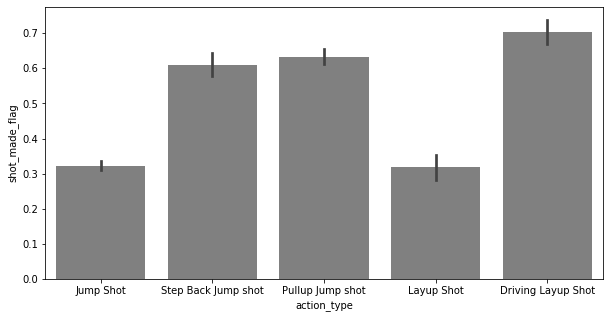

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(x='action_type', y='shot_made_flag', data=common_shots, color='grey');

### homecourt_advantage

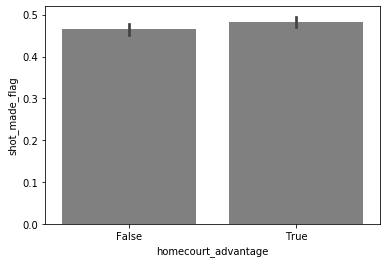

In [12]:
sns.barplot(x='homecourt_advantage', y='shot_made_flag', data=train, color='grey');

### made_previous_shot

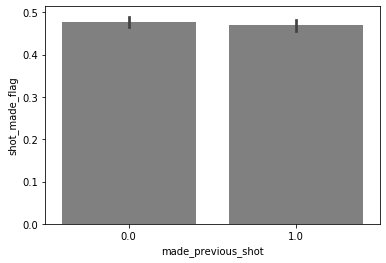

In [13]:
sns.barplot(x='made_previous_shot', y='shot_made_flag', data=train, color='grey');

### shot_distance

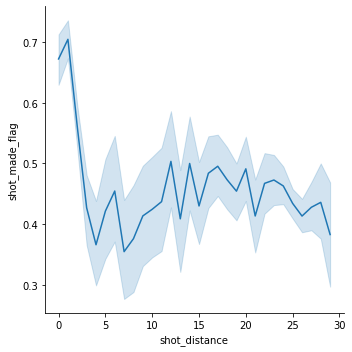

In [14]:
sns.relplot(x='shot_distance', y='shot_made_flag', 
            data=train.query('shot_distance < 30'), kind='line');

### seconds_remaining_period

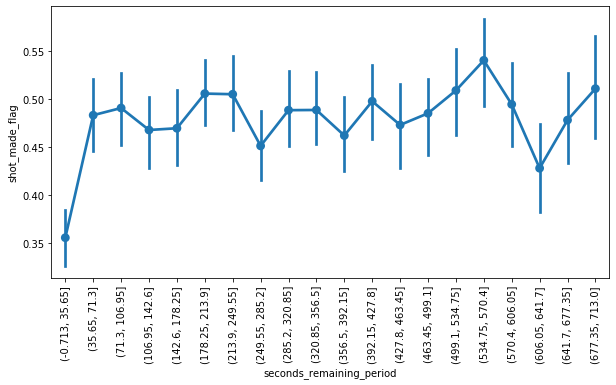

In [15]:
plt.figure(figsize=(10,5))
sns.pointplot(x=pd.cut(train['seconds_remaining_period'], bins=20), 
              y=train['shot_made_flag'])
plt.xticks(rotation=90);

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
val = train['2017-10-01':'2018-09-30']
train = train[:'2017-09-30']

In [17]:
train.index

Index(['2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28',
       '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28',
       ...
       '2017-06-12', '2017-06-12', '2017-06-12', '2017-06-12', '2017-06-12',
       '2017-06-12', '2017-06-12', '2017-06-12', '2017-06-12', '2017-06-12'],
      dtype='object', name='game_date', length=11081)

In [18]:
val.index

Index(['2017-10-17', '2017-10-17', '2017-10-17', '2017-10-17', '2017-10-17',
       '2017-10-17', '2017-10-17', '2017-10-17', '2017-10-17', '2017-10-17',
       ...
       '2018-06-08', '2018-06-08', '2018-06-08', '2018-06-08', '2018-06-08',
       '2018-06-08', '2018-06-08', '2018-06-08', '2018-06-08', '2018-06-08'],
      dtype='object', name='game_date', length=1168)

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
target = 'shot_made_flag'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [29]:
features

Index(['game_id', 'period', 'action_type', 'shot_type', 'shot_zone_basic',
       'shot_zone_area', 'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y',
       'season_type', 'scoremargin_before_shot', 'homecourt_advantage',
       'opponent', 'seconds_remaining_period', 'seconds_remaining_game',
       'made_previous_shot'],
      dtype='object')

In [20]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'season_type',
                                      'opponent'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Sh...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                  

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [21]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.615582191780822


## Stretch Goal: Get and plot your model's feature importances.

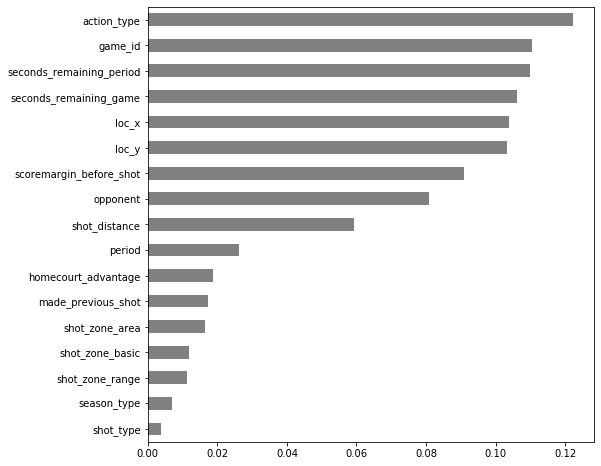

In [22]:
plt.figure(figsize=(8,8))
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

## Stretch Goal: Optimize 3+ hyperparameters 

> by trying 10+ "candidates" (possible combinations of hyperparameters).   
> You can use `RandomizedSearchCV` or do it manually.


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000), 
    'targetencoder__smoothing': uniform(1, 1000), 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])
search.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('targetencoder',
                                              TargetEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            min_samples_leaf=1,
                                                            return_df=True,
                                                            smoothing=1.0,
                                                            verbose=0)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                              

In [24]:
results = pd.DataFrame(search.cv_results_)
cols = ['rank_test_score','mean_test_score']
cols += [col for col in results if col.startswith('param_')]
results[cols].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,param_randomforestclassifier__n_estimators,param_targetencoder__min_samples_leaf,param_targetencoder__smoothing
10,1,0.659727,5,0.654924,490,75,855.597
27,2,0.658829,5,0.492341,383,645,638.391
19,3,0.658176,5,0.366632,61,968,411.745
3,4,0.656543,5,0.536162,195,224,51.0494
24,5,0.655482,5,0.723607,321,155,942.576
18,6,0.649277,5,0.287206,478,66,475.124
22,7,0.632133,5,0.188961,288,163,510.419
21,8,0.625602,10,0.525715,230,743,912.914
8,9,0.624459,10,0.930555,160,402,399.241
20,10,0.623724,10,0.726811,125,736,900.213


## 7. Get your model's test accuracy

> (One time, at the end.)

In [25]:
pipeline = search.best_estimator_
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.6243417203042715


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [26]:
tp = 36
tn = 85
fp = 58
fn = 8

accuracy = (tp + tn) / (tp + tn + fp + fn)
print('Accuracy', accuracy)

Accuracy 0.6470588235294118


### Calculate precision

In [27]:
# https://en.wikipedia.org/wiki/Precision_and_recall
precision = tp / (tp + fp)
print('Precision', precision)

Precision 0.3829787234042553


### Calculate recall

In [28]:
recall = tp / (tp + fn)
print('Recall', recall)

Recall 0.8181818181818182
